In [48]:
import os
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt

from utils import utils, warp, image_utils, constant_var
from options import fake_options
import cv2

In [49]:
# if want to run on CPU, please make it False
constant_var.USE_CUDA = True
utils.fix_randomness()

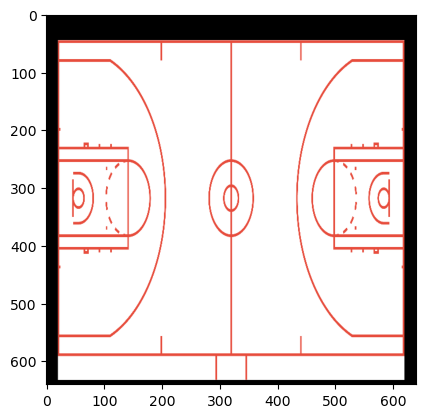

(640, 640)

In [50]:
# overload goal image
template_image_draw = imageio.v2.imread("../data/nba_template.png", pilmode='RGB')
template_image_draw = template_image_draw / 255.0
template_image_draw = cv2.resize(template_image_draw, (640, 640))
outshape = template_image_draw.shape[0:2]
plt.imshow(template_image_draw)
plt.show()
template_image_draw = image_utils.rgb_template_to_coord_conv_template(template_image_draw)
template_image_draw = utils.np_img_to_torch_img(template_image_draw)
goal_image = image_utils.normalize_single_image(template_image_draw)
outshape

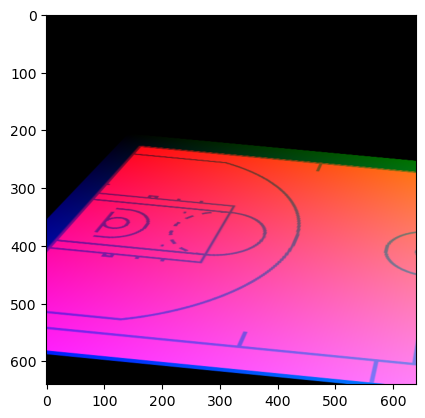

In [51]:
# this is very clutch because the homography was generated with *normalized* (scaling by 1/640 and translated by -0.5) inputted points
# i know i can find the higher scale output space !!!!
# homography = np.float32([[4.79256201e-01, 1.33222063e-02, -2.87431549e-01],
#                          [-1.96539280e-01, 1.74233490e+00, -1.72854768e-01],
#                          [1.27810697e-03, 8.93250457e-01, 1.00000000e+00]])
homography = np.float32([[ .50682884, .08280597, -.28755695],
                          [-0.17313569, 1.80297982, -0.1727644 ],
                          [-.06241396, .74087501, 1.]])
warped_tmp_orig = warp.warp_image(template_image_draw, utils.to_torch(homography), out_shape=outshape)[0]
warped_tmp_orig = utils.torch_img_to_np_img(warped_tmp_orig)
plt.imshow(warped_tmp_orig)
plt.show()

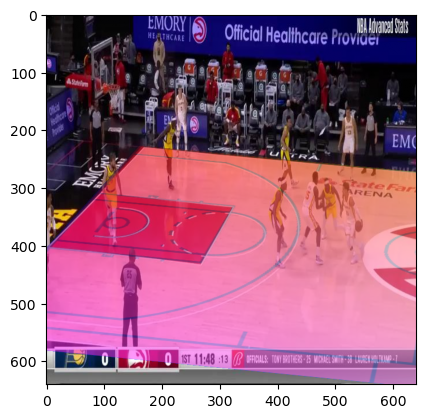

(640, 640)

In [52]:
# show initial guess overlay
goal_image_draw = imageio.v2.imread("../../data/Basketball.v1i.multiclass/train/frame_000000--3-_PNG.rf.0304241253f4a76b0963efc9577fcfd1.jpg", pilmode='RGB')
goal_image_draw = goal_image_draw / 255.0
outshape = goal_image_draw.shape[0:2]
show_image = np.copy(goal_image_draw)
valid_index = warped_tmp_orig[:, :, 0] > 0.0
overlay = (goal_image_draw[valid_index].astype('float32') + warped_tmp_orig[valid_index].astype('float32'))/2
show_image[valid_index] = overlay
plt.imshow(show_image)
plt.show()
outshape

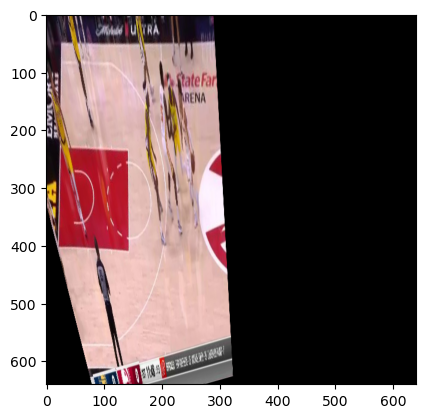

In [53]:
inv_homo = np.linalg.inv(homography)
inv_homo /= inv_homo[2,2]
goal_image_draw = imageio.v2.imread("../../data/Basketball.v1i.multiclass/train/frame_000000--3-_PNG.rf.0304241253f4a76b0963efc9577fcfd1.jpg", pilmode='RGB')
goal_image_draw = goal_image_draw / 255.0
# goal_image_draw = image_utils.rgb_template_to_coord_conv_template(goal_image_draw)
goal_image_draw = utils.np_img_to_torch_img(goal_image_draw)
# goal_image_draw = image_utils.normalize_single_image(goal_image_draw)
warped_court = warp.warp_image(goal_image_draw, utils.to_torch(inv_homo), out_shape=outshape)[0]
warped_court = utils.torch_img_to_np_img(warped_court)
plt.imshow(warped_court)
plt.show()

## Opening the DataLoader and visualizing the homographies

In [54]:
from options import options
from torch.utils.data import DataLoader
from datasets import aligned_dataset
from argparse import Namespace

In [55]:
opt = Namespace(dataset_name='nba', template_path='../data/nba_template.png', coord_conv_template=True, need_single_image_normalization=True,
                root_dir_path='../../data/custom_nba_broadcast')

train_dataset = aligned_dataset.AlignedDatasetFactory.get_aligned_dataset(opt, 'train')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

In [56]:
loader_iterator = enumerate(train_loader)

In [57]:
_, batch = next(loader_iterator)
imgs, warped_templates, gt_homographies = batch

C:\Users\moham\anaconda3\lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [58]:
img0 = imgs[0]
img0 = image_utils.normalize_single_image(img0)
np_img0 = utils.torch_img_to_np_img(img0)
np_img0 = cv2.cvtColor(np_img0, cv2.COLOR_RGB2BGR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


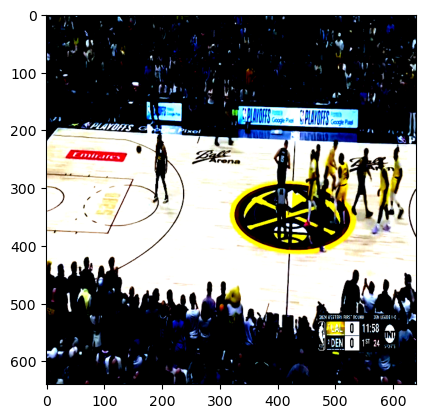

In [59]:
plt.imshow(np_img0)
plt.show()

In [60]:
homography0 = gt_homographies[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


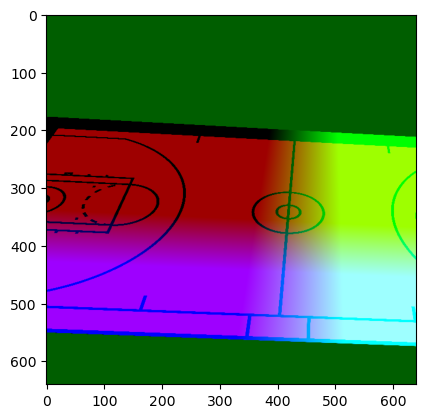

In [61]:
warped_template = warped_templates[0]
# warped_template = warped_template / 255.0
warped_template = image_utils.normalize_single_image(warped_template)
warped_template = utils.torch_img_to_np_img(warped_template)
plt.imshow(warped_template)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


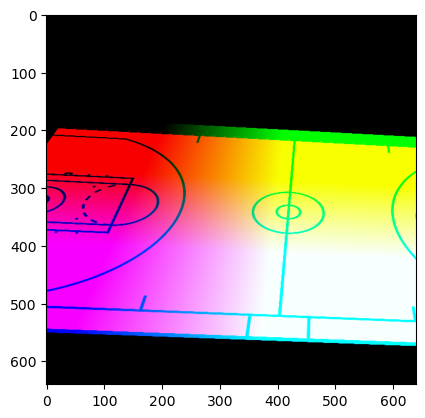

In [62]:
template_image_draw = imageio.v2.imread("../data/nba_template.png", pilmode='RGB')
template_image_draw = template_image_draw / 255.0
template_image_draw = image_utils.rgb_template_to_coord_conv_template(template_image_draw)
template_image_draw = utils.np_img_to_torch_img(template_image_draw)
warped_court = warp.warp_image(template_image_draw, homography0, out_shape=(640,640))[0]
warped_court = image_utils.normalize_single_image(warped_court)
warped_court = utils.torch_img_to_np_img(warped_court)
plt.imshow(warped_court)
plt.show()


## Testing the initial guess model with an image from the test  dataset

In [63]:
from models import init_guesser, end_2_end_optimization_helper

In [64]:
opt = Namespace(dataset_name='nba', template_path='../data/nba_template.png', coord_conv_template=True, need_single_image_normalization=True,
                root_dir_path='../../data/custom_nba_broadcast', canon4pts_type='six', guess_model='init_guess', load_weights_upstream='pretrained_init_guess',
                imagenet_pretrain=False, out_dir='../out')

In [65]:
# loading the test dataset
test_dataset = aligned_dataset.AlignedDatasetFactory.get_aligned_dataset(opt, 'test')
test_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

In [66]:
# loading the inputs of one annotation
loader_iterator = enumerate(test_loader)
_, batch = next(loader_iterator)
imgs, warped_templates, gt_homographies = batch

C:\Users\moham\anaconda3\lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


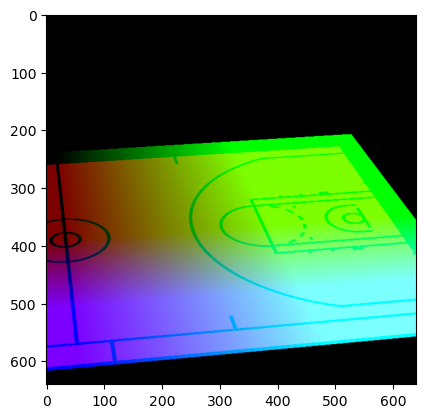

In [67]:
# warped template based on the current image and it's attached homography
warped_template = utils.torch_img_to_np_img(warped_templates[0])
plt.imshow(warped_template)
plt.show()

In [68]:
# loading the model
initial_guesser = init_guesser.InitialGuesserFactory.get_initial_guesser(opt)
initial_guesser = utils.set_model_device(initial_guesser)

PRETRAINED: False
---------------------- NOTIFICATION ----------------------

Resnet backbone config for init_guess
Spectral norm for resnet: False
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
CHECKPOINT_PATH: 47
feature_extractor.conv1.weight
feature_extractor.bn1.weight
feature_extractor.bn1.bias
feature_extractor.bn1.running_mean
feature_extractor.bn1.running_var
feature_extractor.bn1.num_batches_tracked
feature_extractor.layer1.0.conv1.weight
feature_extractor.layer1.0.bn1.weight
feature_extractor.layer1.0.bn1.bias
feature_extractor.layer1.0.bn1.running_mean
feature_extractor.layer1.0.bn1.running_var
feature_extractor.layer1.0.bn1.num_batches_tracked
feature_extractor.layer1.0.conv2.weight
feature_extractor.layer1.0.bn2.weight
feature_extractor.layer1.0.bn2.bias
feature_extractor.layer1.0.bn2.running_mean
feature_extractor.layer1.0.bn2.running_var
feature_extractor.layer1.0.bn2.num_batches_tracked
feature

In [69]:
from torchsummary import summary
summary(initial_guesser, (3, 640, 640))

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 12]                  --
|    └─Conv2d: 2-1                       [-1, 64, 320, 320]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 320, 320]        128
|    └─ReLU: 2-3                         [-1, 64, 320, 320]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 160, 160]        --
|    └─Sequential: 2-5                   [-1, 64, 160, 160]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 160, 160]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 160, 160]        73,984
|    └─Sequential: 2-6                   [-1, 128, 80, 80]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 80, 80]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 80, 80]         295,424
|    └─Sequential: 2-7                   [-1, 256, 40, 40]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 40, 40]     

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 12]                  --
|    └─Conv2d: 2-1                       [-1, 64, 320, 320]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 320, 320]        128
|    └─ReLU: 2-3                         [-1, 64, 320, 320]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 160, 160]        --
|    └─Sequential: 2-5                   [-1, 64, 160, 160]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 160, 160]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 160, 160]        73,984
|    └─Sequential: 2-6                   [-1, 128, 80, 80]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 80, 80]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 80, 80]         295,424
|    └─Sequential: 2-7                   [-1, 256, 40, 40]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 40, 40]     

In [70]:
# estimate the warped corners with the fine tuned init guesser
with torch.no_grad():
    initial_guesser.eval()
    inferred_corners = initial_guesser(imgs)
inferred_corners = inferred_corners[0]
inferred_corners = inferred_corners.reshape(-1, 6, 2)
inferred_corners

tensor([[[-0.0627, -1.0251],
         [ 0.0296, -0.1237],
         [-0.0689,  0.5047],
         [ 0.6948, -0.8462],
         [ 0.2901,  0.5923],
         [ 0.5461,  0.0572]]], device='cuda:0')

In [71]:
# generate homography based on estimate
inferred_corners = inferred_corners.cpu().numpy()
inferred_homography, _ = cv2.findHomography(utils.CANON6PTS_NP(), inferred_corners, cv2.RANSAC)
inferred_homography

array([[ 0.56341836, -0.08865646,  0.24465246],
       [ 0.15683478,  1.83958992, -0.2029789 ],
       [-0.0102162 ,  0.66261619,  1.        ]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


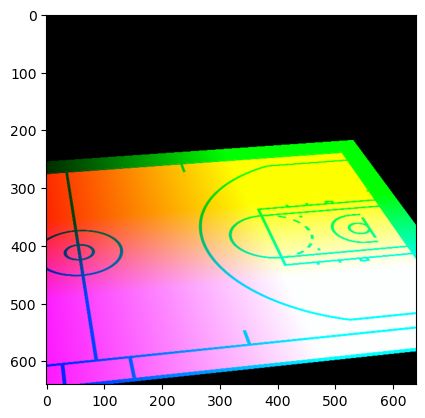

In [72]:
# display resulting homography from estimate
template_image_draw = imageio.v2.imread("../data/nba_template.png", pilmode='RGB')
template_image_draw = template_image_draw / 255.0
template_image_draw = image_utils.rgb_template_to_coord_conv_template(template_image_draw)
template_image_draw = utils.np_img_to_torch_img(template_image_draw)
warped_court = warp.warp_image(template_image_draw, utils.to_torch(inferred_homography), out_shape=(640,640))[0]
warped_court = image_utils.normalize_single_image(warped_court)
warped_court = utils.torch_img_to_np_img(warped_court)
plt.imshow(warped_court)
plt.show()
